# 오토인코더를 사용하여 이미지 잡음 제거

### STEP #1: 라이브러리 및 데이터셋 불러오기

In [56]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import seaborn as sns
import random 

In [21]:
# keras 라이브러리 불러오기
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras import regularizers
from keras.layers import Dropout
from keras.callbacks import ModelCheckpoint

In [2]:
# 이미지 분류기를 위해 다양한 카테고리를 가진 cifar10 데이터셋 사용
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()


In [3]:
X_train.shape

(50000, 32, 32, 3)

In [4]:
X_test.shape

(10000, 32, 32, 3)

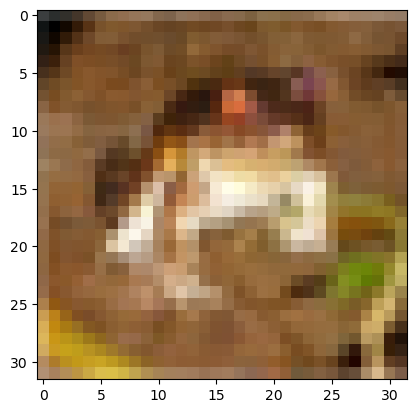

In [5]:
plt.imshow(X_train[0], cmap="gray")

### STEP #2: 데이터 이미지 출력

c:\Users\hks56\anaconda3\lib\site-packages\matplotlib\text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


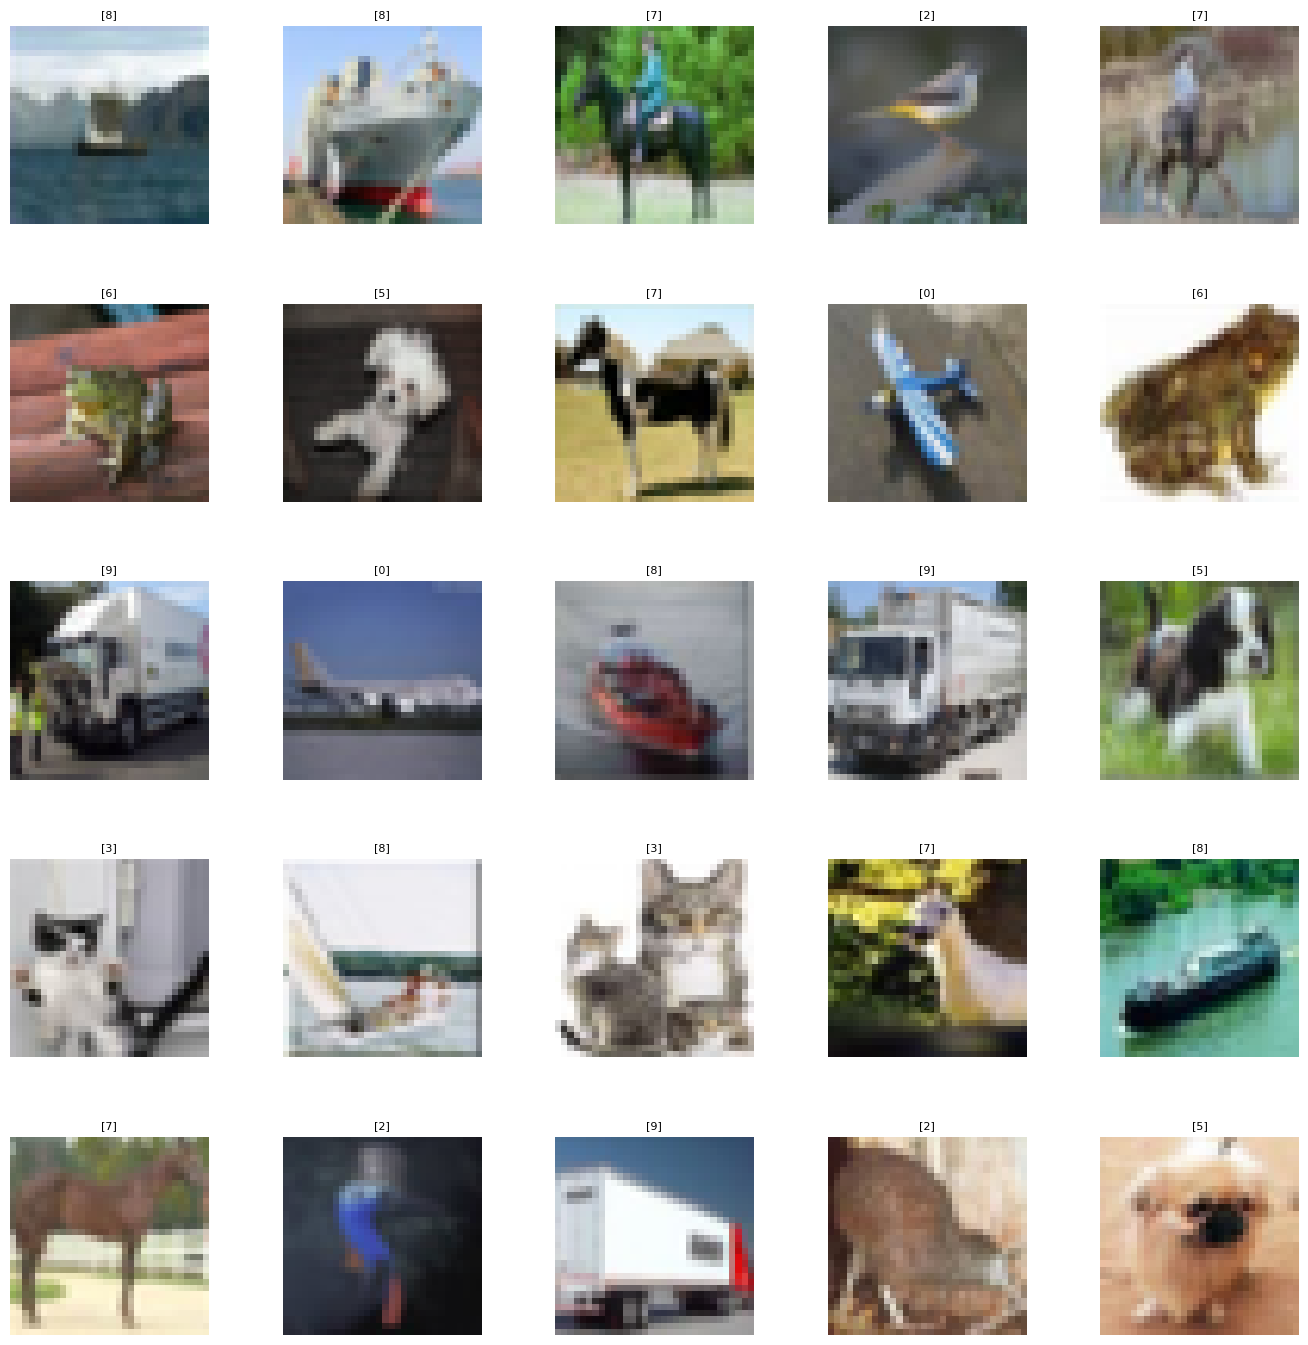

In [6]:
# 이미지 여러 개 출력
# 15 * 15 형식으로 출력
W_grid = 15
L_grid = 15

# subplots()함수 fig, axes 객체 리턴
fig, axes = plt.subplots(5, 5, figsize = (17,17))

# 15 * 15 행렬을 255크기의 배열로 바꿈
axes = axes.ravel() 

# 훈련용 데이터셋 크기 반환
n_training = len(X_train) 

# 0 ~ n_training 까지 중 랜덤한 인덱스의 데이터 이미지 출력
for i in np.arange(0, 5*5): 
    # 랜덤한 인덱스 지정
    index = np.random.randint(0, n_training)
    # 인덱스에 해당하는 데이터 이미지 출력
    axes[i].imshow( X_train[index] )
    axes[i].set_title(y_train[index], fontsize = 8)
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.4)

### STEP #3: 이미지 노이즈 추가

In [7]:
X_train = X_train / 255
X_test = X_test / 255

In [8]:
# 노이즈 강도 0.3
noise_factor = 0.3

# 노이즈 추가된 이미지 저장할 배열
noise_dataset = []

# 훈련용 데이터 노이즈 추가
for img in X_train:
  noisy_image = img + noise_factor * np.random.randn(*img.shape) # 이미지 픽셀에 노이즈 추가
  noisy_image = np.clip(noisy_image, 0., 1.) # 이미지 클리핑
  noise_dataset.append(noisy_image) # 노이즈 추가된 이미지 noise_dataset 배열에 추가

noise_dataset = np.array(noise_dataset)
noise_dataset.shape

(50000, 32, 32, 3)

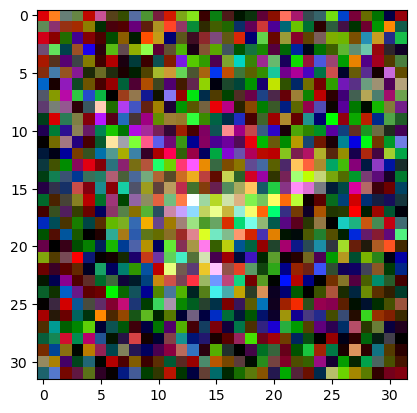

In [9]:
# 노이즈 추가된 이미지 하나 임의 출력
plt.imshow(noise_dataset[22], cmap="gray")

In [10]:
# 검증용 데이터 노이즈 추가
noise_test_set = []
for img in X_test:
  noisy_image = img + noise_factor * np.random.randn(*img.shape) # 이미지 픽셀에 노이즈 추가
  noisy_image = np.clip(noisy_image, 0., 1.) # 이미지 클리핑
  noise_test_set.append(noisy_image)  # 노이즈 추가된 이미지 noise_dataset 배열에 추가
  
noise_test_set = np.array(noise_test_set)
noise_test_set.shape

(10000, 32, 32, 3)

### STEP #4: 오토인코더 모델 설계 및 훈련(.fit())

In [11]:
# 입력 이미지의 형태 저장
input_shape = X_train.shape[1:]

# 오토인코더 모델 생성
autoencoder = tf.keras.models.Sequential([
    ### 인코더 부분
    # 이미지 특성 추출
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
    # 2x2 최대 풀링을 사용하여 이미지 크기를 1/2배 (차원 축소 및 압축)
    tf.keras.layers.MaxPooling2D((2, 2), padding='same'),
    # 이미지 특성 추출
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    
    ### 디코더 부분
    # 2x2 업샘플링을 사용하여 이미지 크기를 2배 (차원 복원 및 복원)
    tf.keras.layers.UpSampling2D((2, 2)),
    # 이미지 특성 추출
    tf.keras.layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')
])


In [12]:
# 오토인코더 모델 컴파일
autoencoder.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=0.001))
# 오토인코더 모델 요약 출력
autoencoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 32)        9248      
                                                                 
 up_sampling2d (UpSampling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 3)         867       
                                                                 
Total params: 11,011
Trainable params: 11,011
Non-traina

In [13]:
# 데이터 훈련
autoencoder.fit(noise_dataset, X_train, epochs=10, batch_size=128, validation_data=(noise_test_set, X_test))

Epoch 1/10
391/391 [==============================] - 226s 573ms/step - loss: 0.5788 - val_loss: 0.5711
Epoch 2/10
391/391 [==============================] - 225s 575ms/step - loss: 0.5691 - val_loss: 0.5691
Epoch 3/10
391/391 [==============================] - 245s 627ms/step - loss: 0.5675 - val_loss: 0.5679
Epoch 4/10
391/391 [==============================] - 132s 337ms/step - loss: 0.5666 - val_loss: 0.5672
Epoch 5/10
391/391 [==============================] - 134s 343ms/step - loss: 0.5662 - val_loss: 0.5669
Epoch 6/10
391/391 [==============================] - 132s 336ms/step - loss: 0.5659 - val_loss: 0.5666
Epoch 7/10
391/391 [==============================] - 104s 266ms/step - loss: 0.5658 - val_loss: 0.5665
Epoch 8/10
391/391 [==============================] - 108s 277ms/step - loss: 0.5656 - val_loss: 0.5664
Epoch 9/10
391/391 [==============================] - 118s 300ms/step - loss: 0.5655 - val_loss: 0.5664
Epoch 10/10
391/391 [==============================] - 107s 272m

### STEP #5: 모델 성능 측정 및 노이즈 제거 예시 출력

In [14]:
# 모델 성능 측정 (예측 정확도 파라미터)
evaluation = autoencoder.evaluate(noise_test_set, X_test)
print('Test Accuracy : {:.3f}'.format(evaluation))

313/313 [==============================] - 6s 20ms/step - loss: 0.5665
Test Accuracy : 0.566


In [36]:
# 오토인코더 노이즈 제거 출력을 위한 예측 결과 저장
predicted = autoencoder.predict(noise_test_set[:10000])

313/313 [==============================] - 8s 25ms/step


In [37]:
predicted.shape

(10000, 32, 32, 3)

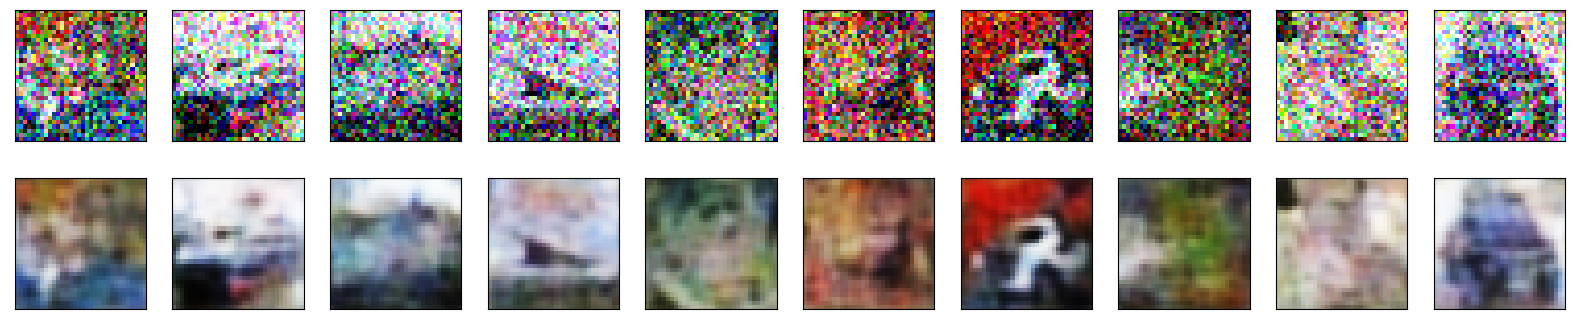

In [38]:
# 예측 결과 출력
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
for images, row in zip([noise_test_set[:10], predicted], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((32, 32, 3)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

# Classification 수행

### STEP #1 : 오토인코더를 거친 잡음제거 이미지 데이터 훈련용/검증용 분류

In [43]:
from sklearn.model_selection import train_test_split

# 정답레이블 개수와 오토 인코더를 통해 잡음제거된 이미지 개수를 10000개로 통일하여 입력 데이터 크기 일치시킴
X_train = X_train[:10000]
y_train = y_train[:10000]

#cifar-10 데이터의 클래스 수 = 10
num_classes = 10

# 이미지 분류기 정답 레이블 생성
y_train_classifier = tf.keras.utils.to_categorical(y_train, num_classes)
y_test_classifier = tf.keras.utils.to_categorical(y_test, num_classes)

# 검증용 데이터와 훈련용 데이터로 분류
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(predicted, y_train_classifier, test_size=0.2, random_state=42)

### STEP #2 : 이미지 분류기 모델 생성

In [48]:
classifier = tf.keras.models.Sequential([
    # Step 1 - Convolution
    tf.keras.layers.Conv2D(128, (3, 3), input_shape=(32, 32, 3), activation='relu'),
    
    # Adding another layer
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    
    # Pooling
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    
    # Adding another layer
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    
    # Pooling
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    
    # Adding another layer
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    
    # Pooling
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    
    # Flatten the layer
    tf.keras.layers.Flatten(),
    
    # Fully connected layer
    tf.keras.layers.Dense(128, activation='relu'),
    
    # Output layer
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [49]:
classifier.summary()
classifier.compile(optimizer = 'adam',loss = 'categorical_crossentropy', metrics = ['accuracy'])

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_19 (Conv2D)          (None, 30, 30, 128)       3584      
                                                                 
 conv2d_20 (Conv2D)          (None, 28, 28, 64)        73792     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 14, 14, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 12, 12, 32)        18464     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 6, 6, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 4, 4, 32)         

In [50]:
classifier.fit(X_train_class, y_train_class, batch_size=32, epochs=10, validation_data=(X_test_class, y_test_class))

Epoch 1/10
250/250 [==============================] - 59s 230ms/step - loss: 2.3034 - accuracy: 0.0971 - val_loss: 2.3027 - val_accuracy: 0.0935
Epoch 2/10
250/250 [==============================] - 56s 224ms/step - loss: 2.3027 - accuracy: 0.1025 - val_loss: 2.3028 - val_accuracy: 0.0935
Epoch 3/10
250/250 [==============================] - 49s 195ms/step - loss: 2.3027 - accuracy: 0.0991 - val_loss: 2.3028 - val_accuracy: 0.0985
Epoch 4/10
250/250 [==============================] - 58s 232ms/step - loss: 2.3026 - accuracy: 0.1009 - val_loss: 2.3028 - val_accuracy: 0.0985
Epoch 5/10
250/250 [==============================] - 74s 297ms/step - loss: 2.3024 - accuracy: 0.1042 - val_loss: 2.3030 - val_accuracy: 0.0935
Epoch 6/10
250/250 [==============================] - 42s 169ms/step - loss: 2.3024 - accuracy: 0.1020 - val_loss: 2.3031 - val_accuracy: 0.0935
Epoch 7/10
250/250 [==============================] - 42s 167ms/step - loss: 2.3024 - accuracy: 0.1030 - val_loss: 2.3031 - val_ac

In [51]:
class_predicted = classifier.predict(X_test_class)

63/63 [==============================] - 4s 63ms/step


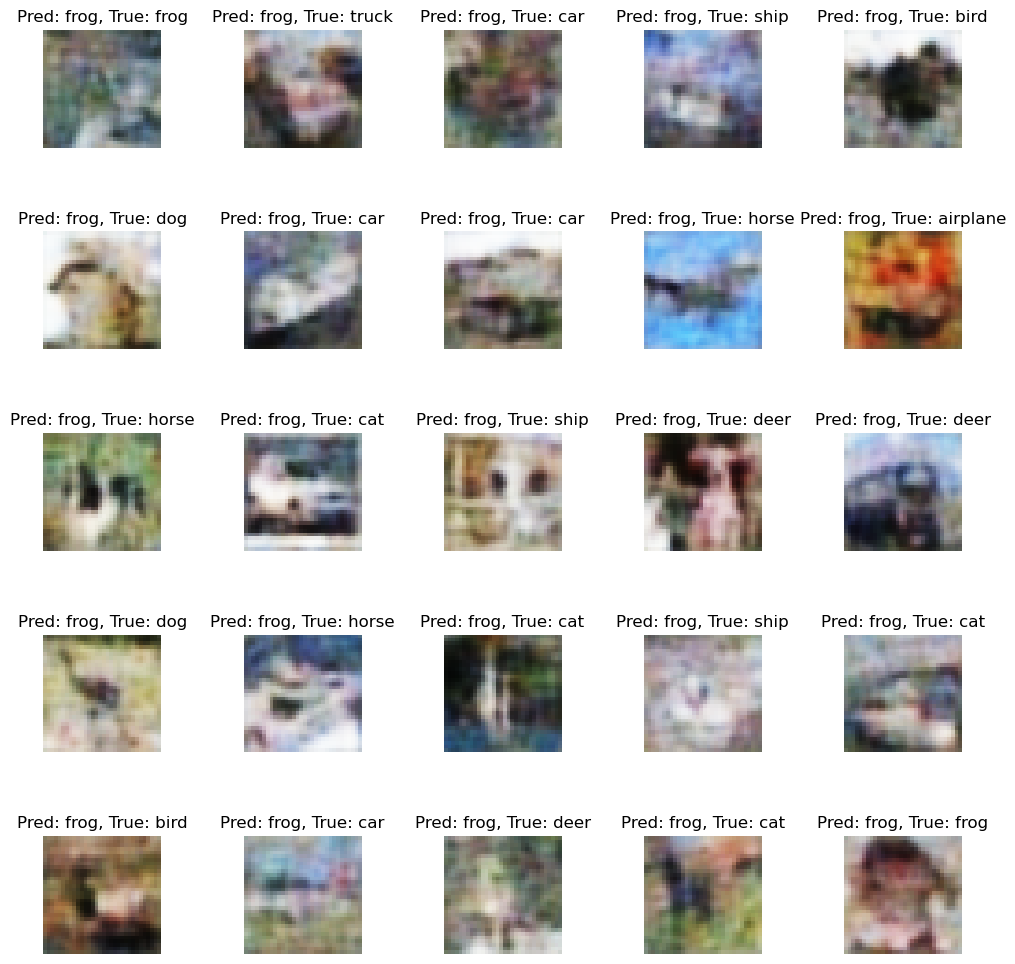

In [67]:
import numpy as np
import matplotlib.pyplot as plt

class_names = ['airplane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# 예측 결과 출력
predicted_labels = np.argmax(class_predicted, axis=1)
true_labels = np.argmax(y_test_class, axis=1)

# 예측 결과 시각화
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(10, 10))
fig.tight_layout()

for i, ax in enumerate(axes.flatten()):
    # 이미지 출력
    ax.imshow(X_test_class[i])
    ax.axis('off')

    # 예측된 레이블과 실제 레이블 출력
    predicted_label = class_names[predicted_labels[i]]
    true_label = class_names[true_labels[i]]
    ax.set_title(f'Pred: {predicted_label}, True: {true_label}')

# 이미지 출력 간격 조절
plt.subplots_adjust(wspace=0.7, hspace=0.5)

plt.show()


In [69]:
# 모델 성능 측정 (예측 정확도 파라미터)
class_evaluation = classifier.evaluate(X_test_class, y_test_class)
print('Test Accuracy: {:.3f}'.format(class_evaluation[1]))

63/63 [==============================] - 4s 67ms/step - loss: 2.3031 - accuracy: 0.0935
Test Accuracy: 0.094
